<a href="https://colab.research.google.com/github/rajkachhadiya123/flask-time-series-forecast/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_excel('dataset.xlsx')
df

,OrderDate,ParentProductIdNew,ParentProductNew,ProductCategoryNew,ArtistNameNew,total_qty_sales,Selling Price,productListViews,productListClicks
0,2019-01-01,11,Product 11,Category 1,TSSOS,3,399.000000,NaN,NaN
1,2019-01-01,114,Product 114,Category 8,TSSA,10,549.000000,NaN,NaN
2,2019-01-01,98,Product 98,Category 8,TSSHT,8,499.000000,NaN,NaN
3,2019-01-01,97,Product 97,Category 8,TSSF,6,549.000000,NaN,NaN
4,2019-01-01,8,Product 8,Category 1,TSSML,6,399.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
40558,2020-12-31,18,Product 18,Category 2,TSSDP,19,570.052632,12004.0,104.0
40559,2020-12-31,76,Product 76,Category 6,TSSML,16,861.500000,2367.0,76.0
40560,2020-12-31,21,Product 21,Category 2,TSSML,5,619.000000,3697.0,60.0
40561,2020-12-31,52,Product 52,Category 4,TSSCC,18,1299.000000,34690.0,553.0


# Plot main row

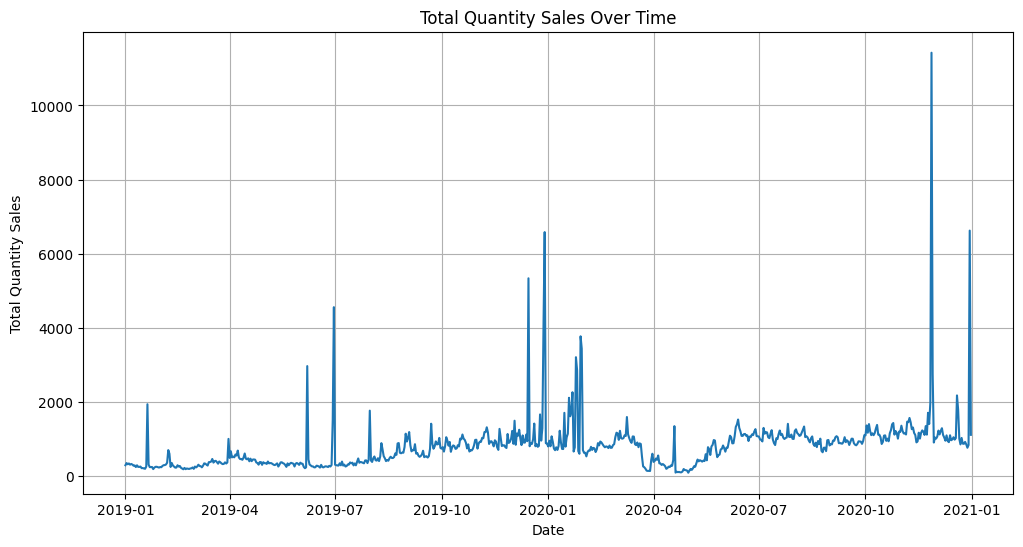

In [ ]:
daily_sales = df.groupby('OrderDate')['total_qty_sales'].sum().reset_index()

daily_sales = daily_sales.set_index('OrderDate')

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['total_qty_sales'])
plt.title('Total Quantity Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sales')
plt.grid(True)
plt.show()

# Set index

In [ ]:
df = df.set_index('OrderDate')
display(df.head())

,ParentProductIdNew,ParentProductNew,ProductCategoryNew,ArtistNameNew,total_qty_sales,Selling Price,productListViews,productListClicks
OrderDate,,,,,,,,
2019-01-01,11,Product 11,Category 1,TSSOS,3,399.0,NaN,NaN
2019-01-01,114,Product 114,Category 8,TSSA,10,549.0,NaN,NaN
2019-01-01,98,Product 98,Category 8,TSSHT,8,499.0,NaN,NaN
2019-01-01,97,Product 97,Category 8,TSSF,6,549.0,NaN,NaN
2019-01-01,8,Product 8,Category 1,TSSML,6,399.0,NaN,NaN


#  Time series decomposition(to understand the data)

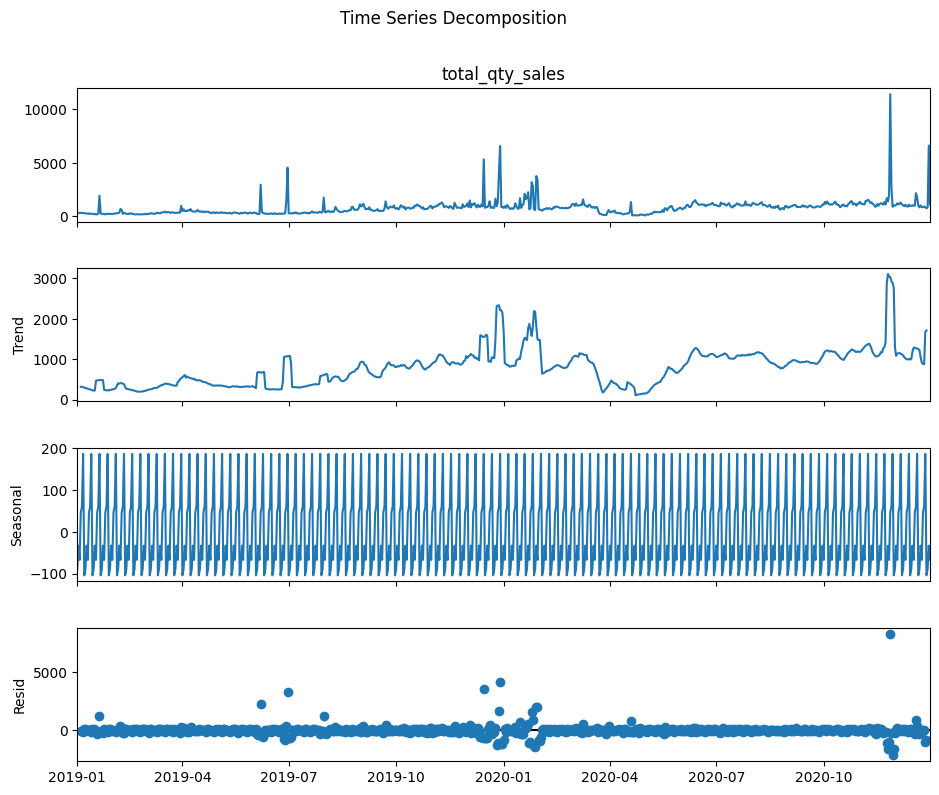

In [ ]:
#daily_sales.index.freq checks if the Pandas DateTimeIndex has a known, regular frequency (like daily, monthly, etc.).
if daily_sales.index.freq is None:
    daily_sales = daily_sales.asfreq('D')

#If no frequency is set (i.e., freq is None), then .asfreq('D') explicitly sets the frequency to daily.


decomposition = seasonal_decompose(daily_sales['total_qty_sales'], model='additive')

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()



#plot : Long-term direction such as upward direction or downward direction
#seasonal : repeating pattern
#resid : noise

# Train ARIMA model

In [ ]:
train = daily_sales[:int(0.8 * len(daily_sales))]
test = daily_sales[int(0.8 * len(daily_sales)):]

model = ARIMA(train['total_qty_sales'], order=(5,1,0))
model_fit = model.fit()


forecast = model_fit.forecast(steps=len(test))

print(model_fit.summary())

print("\nForecast:")
print(forecast)

                               SARIMAX Results                                
Dep. Variable:        total_qty_sales   No. Observations:                  584
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4424.823
Date:                Tue, 17 Jun 2025   AIC                           8861.647
Time:                        15:51:31   BIC                           8887.856
Sample:                    01-01-2019   HQIC                          8871.862
                         - 08-06-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5412      0.014    -40.058      0.000      -0.568      -0.515
ar.L2         -0.5612      0.023    -24.278      0.000      -0.607      -0.516
ar.L3         -0.3881      0.026    -15.011      0.0

# Evaluation of ARIMA

In [ ]:

mean = daily_sales['total_qty_sales'].mean()
std = daily_sales['total_qty_sales'].std()
threshold = mean + 3 * std


cleaned_sales = daily_sales[daily_sales['total_qty_sales'] <= threshold]

scaler = MinMaxScaler()
cleaned_sales['scaled_sales'] = scaler.fit_transform(cleaned_sales[['total_qty_sales']])

forecast_scaled = model_fit.forecast(steps=len(test))

forecast_actual = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1))

results_df = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['total_qty_sales'].values,
    'Forecasted Sales': forecast_actual.flatten()
})


mae = mean_absolute_error(results_df['Actual Sales'], results_df['Forecasted Sales'])
rmse = np.sqrt(mean_squared_error(results_df['Actual Sales'], results_df['Forecasted Sales']))

print(f"Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

Evaluation Metrics:
MAE (Mean Absolute Error): 187.42
RMSE (Root Mean Squared Error): 269.97


# Forecast vs Actual sales

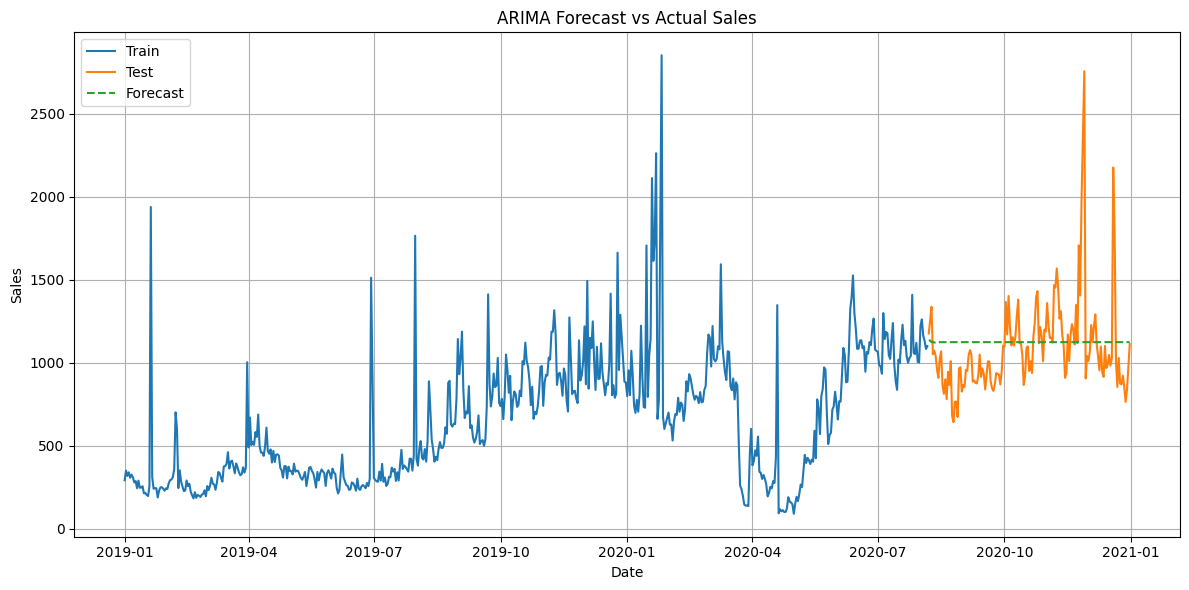


 Forecasted Results:
        Date  Actual Sales  Forecasted Sales
0 2020-08-07          1177       1134.141251
1 2020-08-08          1254       1135.007514
2 2020-08-09          1338       1125.809244
3 2020-08-10          1052       1126.349667
4 2020-08-11          1074       1122.512328
5 2020-08-12          1044       1122.567950
6 2020-08-13           962       1125.782611
7 2020-08-14           910       1125.787847
8 2020-08-15          1023       1124.732584
9 2020-08-16          1070       1125.081125


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_qty_sales'], label='Train')
plt.plot(test.index, test['total_qty_sales'], label='Test')
plt.plot(test.index, forecast_actual, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['total_qty_sales'].values,
    'Forecasted Sales': forecast_actual.flatten()
})
print("\n Forecasted Results:")
print(forecast_df.head(10))

# SARIMAX

In [ ]:
sari_model = SARIMAX(train['total_qty_sales'],
                       order=(1, 1, 1),
                       seasonal_order=(0, 1, 1, 7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_model_fit = sari_model.fit()


# Evaluation of SARIMAX

In [ ]:
forecast_scaled = sarima_model_fit.forecast(steps=len(test))

forecast_actual_sarimax = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1))

results_df_sarimax = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['total_qty_sales'].values,
    'Forecasted Sales': forecast_actual_sarimax.flatten()
})

mae_sarimax_eval = mean_absolute_error(results_df_sarimax['Actual Sales'], results_df_sarimax['Forecasted Sales'])
rmse_sarimax_eval = np.sqrt(mean_squared_error(results_df_sarimax['Actual Sales'], results_df_sarimax['Forecasted Sales']))

print(f"Evaluation Metrics (SARIMAX):")
print(f"MAE (Mean Absolute Error): {mae_sarimax_eval:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_sarimax_eval:.2f}")

Evaluation Metrics (SARIMAX):
MAE (Mean Absolute Error): 277.35
RMSE (Root Mean Squared Error): 330.39


# Forecast vs Actual sales

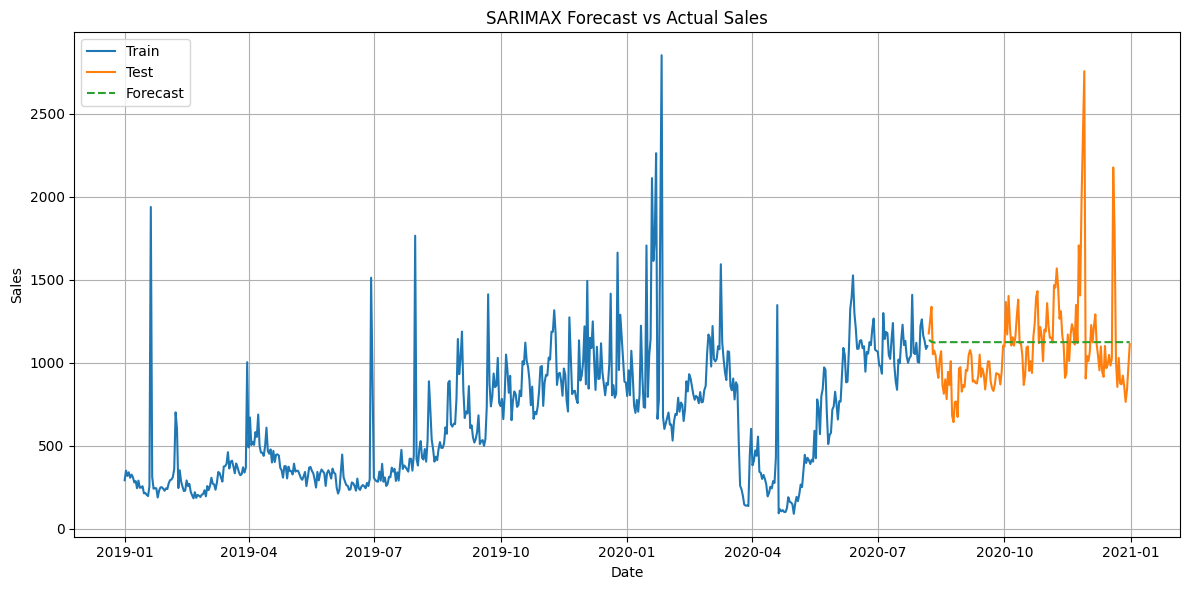


 Forecasted Results:
        Date  Actual Sales  Forecasted Sales
0 2020-08-07          1177       1134.141251
1 2020-08-08          1254       1135.007514
2 2020-08-09          1338       1125.809244
3 2020-08-10          1052       1126.349667
4 2020-08-11          1074       1122.512328
5 2020-08-12          1044       1122.567950
6 2020-08-13           962       1125.782611
7 2020-08-14           910       1125.787847
8 2020-08-15          1023       1124.732584
9 2020-08-16          1070       1125.081125


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_qty_sales'], label='Train')
plt.plot(test.index, test['total_qty_sales'], label='Test')
plt.plot(test.index, forecast_actual, label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['total_qty_sales'].values,
    'Forecasted Sales': forecast_actual.flatten()
})
print("\n Forecasted Results:")
print(forecast_df.head(10))

In [ ]:

mae_arima = 187.42
rmse_arima = 269.97


mae_sarimax = 277.35
rmse_sarimax = 330.39


print("Comparison of Model Accuracy:")
print(f"ARIMA Model:")
print(f"  MAE: {mae_arima:.2f}")
print(f"  RMSE: {rmse_arima:.2f}")
print("\nSARIMAX Model:")
print(f"  MAE: {mae_sarimax:.2f}")
print(f"  RMSE: {rmse_sarimax:.2f}")



Comparison of Model Accuracy:
ARIMA Model:
  MAE: 187.42
  RMSE: 269.97

SARIMAX Model:
  MAE: 277.35
  RMSE: 330.39


# Flask API


In [ ]:
import pickle

# Save ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Save SARIMA model
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model_fit, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)